In [1]:
# Q&A applications want to allow the user to have a back and forth conversation , meaning the applicatoin needs memory of past Q&A and some logic to incorporate that into current thinkiing

We will cover two approaches:

1. Chains, in which we always execute a retrieval step;
2. Agents, in which we give an LLM discretion over whether and how to execute a retrieval step (or multiple steps).

## Chains 

In [4]:
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["LANGCHAIN_TRACING_V2"] = "true"

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-3.5-turbo")

import bs4
from langchain import hub
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000 , chunk_overlap = 200)
splits = text_splitter.split_documents(docs)
vector_store = Chroma.from_documents(documents=splits , embedding= OpenAIEmbeddings())
retriever = vector_store.as_retriever()


system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}")
    ])

question_answer_chain = create_stuff_documents_chain(llm , prompt)
rag_chain = create_retrieval_chain(retriever , question_answer_chain)

In [5]:
response = rag_chain.invoke({"input": "What is Task Decomposition?"})
response["answer"]

'Task decomposition involves breaking down a complex task into smaller and simpler steps to make it more manageable. Techniques like Chain of Thought (CoT) and Tree of Thoughts are used to guide models in decomposing hard tasks into multiple manageable tasks by exploring different reasoning possibilities at each step. Task decomposition can be facilitated by using simple prompts, task-specific instructions, or human inputs.'

Note that we have used the built-in chain constructors create_stuff_documents_chain and create_retrieval_chain, so that the basic ingredients to our solution are:

1. retriever;
2. prompt;
3. LLM.

### Add Chat History

The chain we have built uses the input query directly to retrieve relevant context. But in a conversational setting, the user query might require conversational context to be understood. 

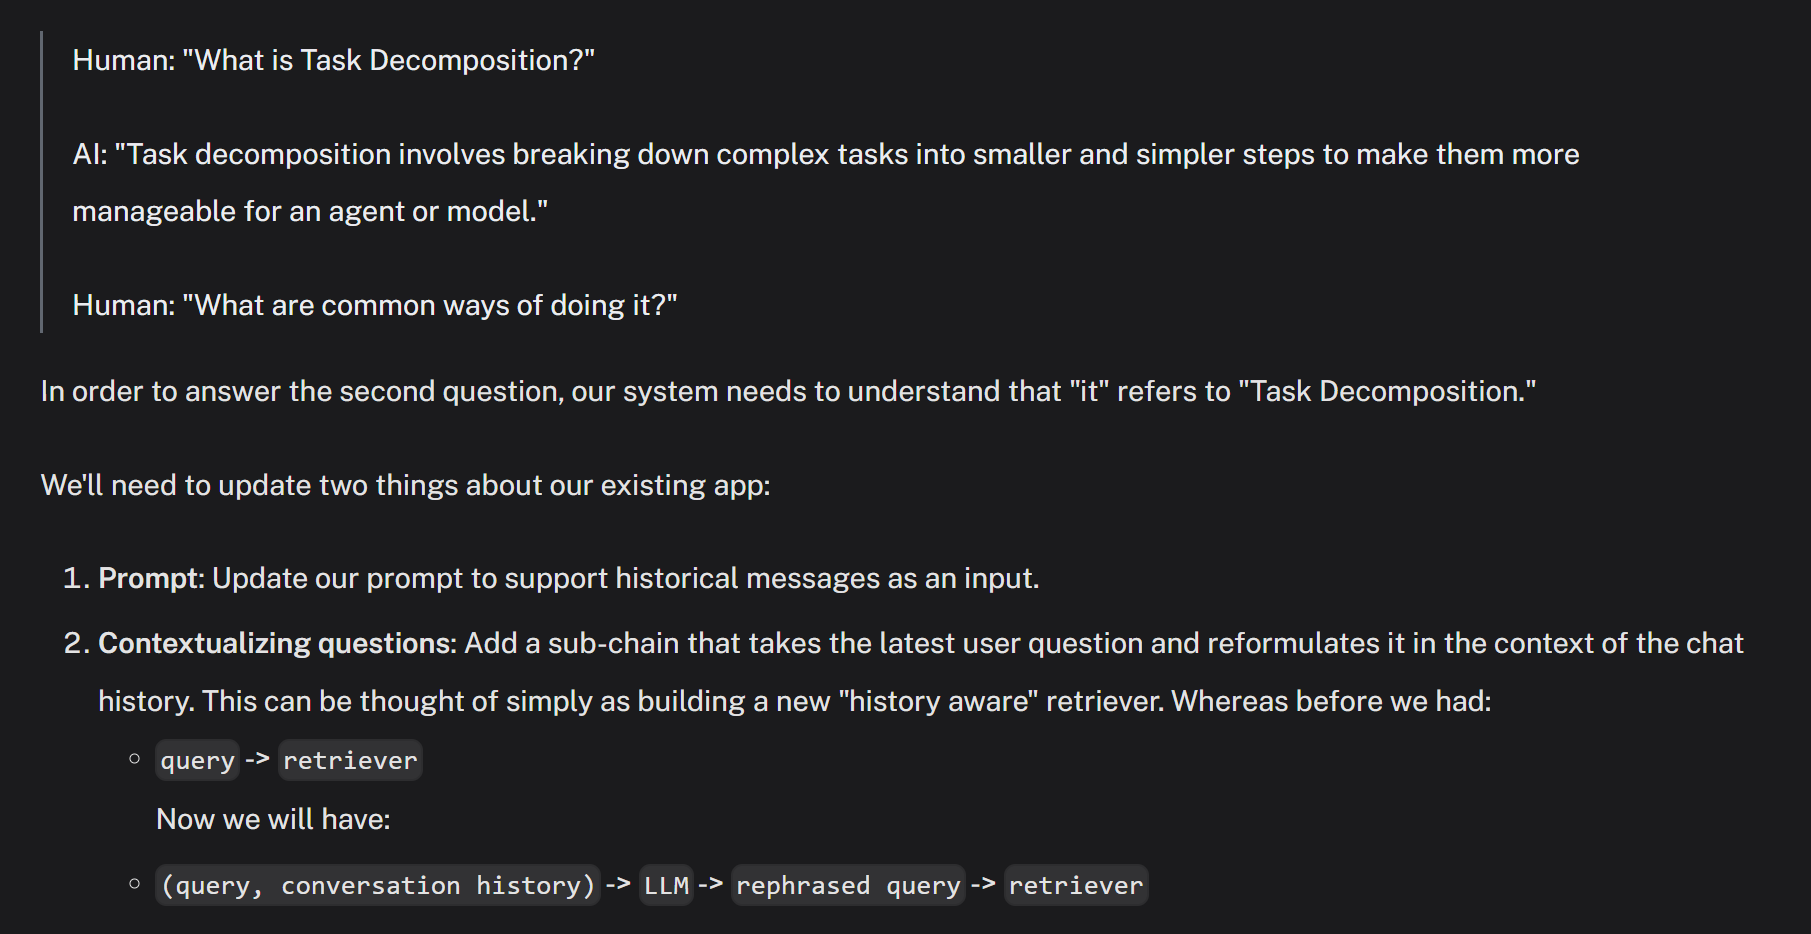

contextualize the question : define a sub chain that takes historical messages and latest user question , and formulates the question if makes reference to any information in the historical information.

Note that we leverage a helper function `create_history_aware_retriever` for this step, which manages the case where chat_history is empty, and otherwise applies prompt | llm | StrOutputParser() | retriever in sequence.

In [ ]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)
